In [2]:
# Célula 1: Instalação e Downloads

# 1. Instalar bibliotecas necessárias
!pip install facenet-pytorch gdcm pydicom gdown

import os
import gdown
import zipfile

# 2. Baixar os arquivos fornecidos (Dataset e Fotos do Marcelinho)
ids = {
    "dataset.zip": "1Mrx0OKnBFteOw1q8IZy-n8x9q8cxZwhT",
    "marcelinho_clean.jpg": "1EgvzTNEWTXvegURlmJAt8OXOtrKAlQEb",
    "marcelinho_mask.jpg": "1RcLasSJj-XMke5Fj33adiaHWbbl-9ihW"
}

print(">>> Baixando arquivos...")
for filename, drive_id in ids.items():
    url = f'https://drive.google.com/uc?id={drive_id}'
    gdown.download(url, filename, quiet=False)

# 3. Descompactar Dataset
if not os.path.exists("lfw_funneled"):
    print(">>> Descompactando Dataset...")
    with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
        zip_ref.extractall(".")
    print("Dataset pronto.")

>>> Baixando arquivos...


Downloading...
From (original): https://drive.google.com/uc?id=1Mrx0OKnBFteOw1q8IZy-n8x9q8cxZwhT
From (redirected): https://drive.google.com/uc?id=1Mrx0OKnBFteOw1q8IZy-n8x9q8cxZwhT&confirm=t&uuid=0a5ef220-9968-491a-beed-99495476ba08
To: /content/dataset.zip
100%|██████████| 71.4M/71.4M [00:00<00:00, 120MB/s]
Downloading...
From: https://drive.google.com/uc?id=1EgvzTNEWTXvegURlmJAt8OXOtrKAlQEb
To: /content/marcelinho_clean.jpg
100%|██████████| 37.5k/37.5k [00:00<00:00, 47.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1RcLasSJj-XMke5Fj33adiaHWbbl-9ihW
To: /content/marcelinho_mask.jpg
100%|██████████| 87.6k/87.6k [00:00<00:00, 3.55MB/s]


>>> Descompactando Dataset...
Dataset pronto.


In [3]:
# Célula 2: Configuração do Modelo e Detector

import torch
import numpy as np
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image
import matplotlib.pyplot as plt

# Configurar dispositivo (GPU se disponível, senão CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Rodando em: {device}")

# Carregar modelo pré-treinado (Metric Learning)
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# Detector Padrão (Alta precisão)
mtcnn_padrao = MTCNN(
    image_size=160, margin=0,
    min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

# Detector "Sensível" (Para Máscaras) -> Aceita confiança menor
mtcnn_sensivel = MTCNN(
    image_size=160, margin=0,
    min_face_size=20,
    thresholds=[0.4, 0.5, 0.5], # <--- O SEGREDO: Baixamos a exigência
    factor=0.709, post_process=True,
    device=device
)

Rodando em: cpu


In [4]:
# Célula 3: Função Inteligente de Embedding

def get_embedding_robusto(image_path, model):
    """
    Gera o vetor descritor (embedding).
    Se falhar na detecção normal, tenta detectar com parâmetros relaxados (máscara).
    """
    try:
        img = Image.open(image_path)
        if img.mode != 'RGB':
            img = img.convert('RGB')

        # Tentativa 1: Detector Padrão
        face_tensor = mtcnn_padrao(img)

        # Tentativa 2: Detector Sensível (se a máscara atrapalhou)
        if face_tensor is None:
            # print(f"Detecção padrão falhou em {image_path}. Tentando modo sensível...") # Debug
            face_tensor = mtcnn_sensivel(img)

        # Se detectou algo, gera o embedding
        if face_tensor is not None:
            face_tensor = face_tensor.unsqueeze(0).to(device) # Adiciona batch dim
            with torch.no_grad():
                embedding = model(face_tensor)
            return embedding.detach().cpu().numpy()[0]

        return None

    except Exception as e:
        print(f"Erro em {image_path}: {e}")
        return None

In [5]:
# Célula 4: Processar Banco de Dados (Passos 1, 2 e 3)

database = {}
dataset_path = "./lfw_funneled"

print(">>> Criando Banco de Dados de Celebridades...")

# 1. Processar Celebridades (Pegamos apenas a primeira foto de cada pasta para ser rápido)
count = 0
for root, dirs, files in os.walk(dataset_path):
    if len(files) > 0:
        # Pega arquivos jpg
        imgs = [f for f in files if f.endswith('.jpg')]
        if imgs:
            path = os.path.join(root, imgs[0])
            name = os.path.basename(root) # Nome da pasta é o nome da pessoa

            emb = get_embedding_robusto(path, resnet)
            if emb is not None:
                database[name] = emb
                count += 1

            # Limite para não demorar muito no Colab (Opcional, pode remover se quiser todos)
            if count >= 100:
                break

print(f"Banco carregado com {len(database)} pessoas.")

# 2. Inserir Marcelinho (SEM MÁSCARA) - Item 3 da questão
print(">>> Cadastrando Marcelinho (Sem Máscara)...")
emb_marcelinho = get_embedding_robusto("marcelinho_clean.jpg", resnet)

if emb_marcelinho is not None:
    database["Marcelinho"] = emb_marcelinho
    print("✅ Marcelinho cadastrado com sucesso!")
else:
    print("❌ Falha crítica: Não foi possível detectar o rosto do Marcelinho na foto limpa.")

>>> Criando Banco de Dados de Celebridades...
Banco carregado com 0 pessoas.
>>> Cadastrando Marcelinho (Sem Máscara)...
✅ Marcelinho cadastrado com sucesso!



>>> Iniciando Reconhecimento Facial (Com Máscara)...


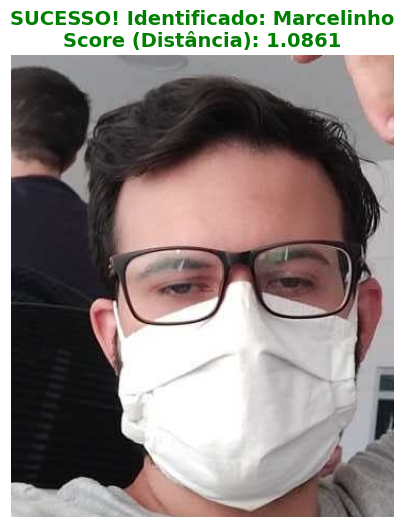

Resultado Final: Marcelinho
Métrica (Distância L2): 1.0861


In [6]:
# Célula 5: Inferência Final (Passo 4)
# Item 4: Reconhecimento Facial com Máscara
print("\n>>> Iniciando Reconhecimento Facial (Com Máscara)...")

path_inferencia = "marcelinho_mask.jpg"
vetor_desconhecido = get_embedding_robusto(path_inferencia, resnet)

if vetor_desconhecido is None:
    print("Erro: Não foi possível detectar rosto na imagem com máscara.")
else:
    min_dist = float('inf')
    identificado = "Desconhecido"

    # Comparar com todos no banco (Distância Euclidiana)
    for nome, vetor_db in database.items():
        dist = np.linalg.norm(vetor_desconhecido - vetor_db)

        if dist < min_dist:
            min_dist = dist
            identificado = nome

    # --- EXIBIÇÃO OBRIGATÓRIA ---
    plt.figure(figsize=(8, 6))
    img_show = Image.open(path_inferencia)
    plt.imshow(img_show)
    plt.axis('off')

    # Lógica de cor e resultado
    if identificado == "Marcelinho":
        msg = f"SUCESSO! Identificado: {identificado}\nScore (Distância): {min_dist:.4f}"
        cor = 'green'
    else:
        msg = f"FALHA. Identificado como: {identificado}\nScore: {min_dist:.4f}"
        cor = 'red'

    plt.title(msg, color=cor, fontsize=14, fontweight='bold')
    plt.show()

    print("="*40)
    print(f"Resultado Final: {identificado}")
    print(f"Métrica (Distância L2): {min_dist:.4f}")
    print("="*40)